# BFF Machine Learning
In this notebook, I'll test some machine learning (ML) algorithms on Brazilian Financial Funds. The inspiration is to create an algorithm able to forecast funds return so investor can plan and adjust their strategy.

THIS IS NOT A FINANCIAL ADVISE, just an experiment to test different ML algorithms and see which one perform better. It is also possible that none will be good, which is fine! This will give enthusiasts insight to keep looking for more variables that may influence funds return.

I'll test the following algorithms:
- Linear Regression
    1. Classic Linear Regression
    2. Stochastic Gradient Descent (SGD)
- Non-linear Regression: 
    1. Support Vector Machine (SVM)
    2. XGBoost
- Neural Networks:
    1. Artificial Neural Networks (ANN)
    2. Recursive Neural Networks (RNN)
    3. Long Short Term Memory (LSTM) - *a type of layer*


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Prepping data
Before I start modeling, I need to make sure my data fits the requeriments of my algorithms. Since I'm dealing with different data scales (monetary, rates, dummy), my models will have a hard time adjusting to it all.

To fix that, I'll use StandardScaler from sklearn to adjust my values based on the standard deviation. This will make sure we have a similar scale to compare my features and will be easier to models to process.

Since my models will use a train, validation and test sets, it's important not influenec the test dataset. So first, I'll:
1. Drops the rows with issues identified on my 'Cleaning Datasets' phase: all data with error on register data
2. Split my dataset in 3: train, validation and test
3. Create a scaler for training and valdiation: later, I'll use the **same** scaler on test set
4. Run my models

In [3]:
# Import financial fund df
fund_df = pd.read_csv('fund_df.csv')

# Drop observations with issue on register
print(f'Fund DF complete: ', fund_df.shape)
fund_df = fund_df[fund_df['correct_name'] == True]

# Fix year_month column to be our index since this is a timeseries
fund_df['year_month'] = pd.to_datetime(fund_df['year_month'])

# Drop COVD 19 outrbreak
fund_df = fund_df[fund_df['year_month'] >= '2023-01-01']

# Drop closed funds due to hardware limitations
fund_df = fund_df[fund_df['SIT_EM FUNCIONAMENTO NORMAL'] >= 1]

# Drops string columns used only in EDA
fund_df = fund_df.drop(columns=['Unnamed: 0','correct_name','DENOM_SOCIAL','DT_COMPTC',
                                'DT_REG','SIT_CANCELADA', 'SIT_FASE PRÉ-OPERACIONAL',
                                'SIT_LIQUIDAÇÃO', 'CONDOM_Fechado','FUNDO_COTAS_N',
                                'FUNDO_EXCLUSIVO_N','manager_name', 'issuer_name', 'big4_name'], axis=1)

# Check the final shape after drops
print(f'Fund DF after drop: ', fund_df.shape)

# # Add macro dataset
# support_df = pd.read_csv('support_df.csv')
# support_df['year_month'] = pd.to_datetime(support_df['year_month'])

# # Merge with financial fund dataframe
# fund_df = pd.merge(fund_df, support_df, how='left',on=['year_month'])

# Set year_month as index to my timeseries issue
fund_df.set_index(['year_month','CNPJ_FUNDO'], inplace=True)

# # Remove outliers
# fund_df[(np.abs(stats.zscore(fund_df)) < 3).all(axis=1)]

Fund DF complete:  (1243297, 30)
Fund DF after drop:  (315769, 16)


In [4]:
# Split features (X) and independent variable (y)
X = fund_df.drop('quota_return', axis=1)
y = fund_df['quota_return']
y = y.reset_index()

# Adjust y dataframe to be just an array with quota return
y = y.drop(columns=['year_month','CNPJ_FUNDO'])

In [5]:
# Create subsets for traininn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Nor subset for validation and test. I'm setting it to 50% so we have an even split between validation and test
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [6]:
# Create scaler
scaler = StandardScaler()

# Fit and transform X_train
scaler.fit_transform(X_train)

# Only transform feature arrays (X)
# scaler.transform(X_val)
scaler.transform(X_test)

array([[-0.02503269, -0.11954532, -0.0730782 , ..., -0.02204037,
        -0.11614359, -0.05063028],
       [-0.02502702, -0.15995166, -0.07286053, ..., -0.02203578,
        -0.16085039, -0.0504842 ],
       [-0.02501748, -0.16264242, -0.0730782 , ..., -0.02202776,
        -0.16349756, -0.05063028],
       ...,
       [-0.0249919 , -0.15961452, -0.07302378, ..., -0.02200642,
        -0.16047474, -0.05059376],
       [-0.02503268, -0.1503091 , -0.0730782 , ..., -0.02204066,
        -0.15259114, -0.05063028],
       [-0.02486446, -0.16480699, -0.0730782 , ..., -0.02189876,
        -0.16564023, -0.05063028]])

## Linear Regression
First, let's try a classic linear regression. I'm trying to predict quota's return (y)

In [6]:
# Create an instance for linear regression model
lm = LinearRegression()

# Fit the model in my training sets (X and y)
lm.fit(X_train,y_train)

# Predict values for validation
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

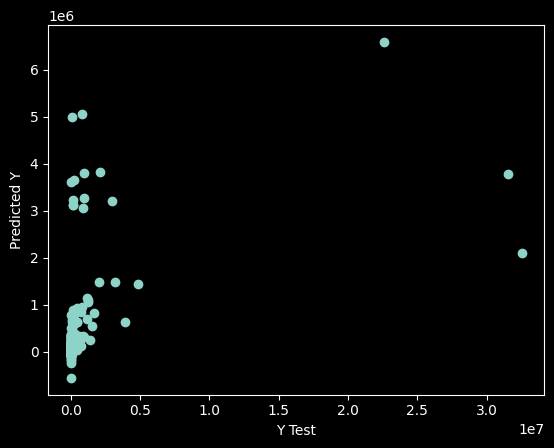

In [7]:
# Plot prediction vs the real result
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [8]:
# Print metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', metrics.r2_score(y_test, predictions))

MAE: 2833.4612631354453
MSE: 22216133853.73996
RMSE: 149050.7760923772
R2: 0.2063746809228999


In [9]:
# Create an instance for SGD
sgd = SGDRegressor()

# Fit the model in my training sets (X and y)
sgd.fit(X_train,y_train)

# Predict values for validation
predictions_sgd = sgd.predict(X_test)

d:\Documentos\My_Py_Projects\github_DS_projects\data-science-projects\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Print metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions_sgd))
print('MSE:', metrics.mean_squared_error(y_test, predictions_sgd))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_sgd)))
print('R2:', metrics.r2_score(y_test, predictions_sgd))

MAE: 1.1522118658675142e+27
MSE: 4.559458450002044e+55
RMSE: 6.752376211380734e+27
R2: -1.6287719956244766e+45


## Non-Linear Regression
Seems like my linear model didn't perform well. Let's try non-linear models to see if I can get an improvement on my predictions.

### Support Vector Machines (SVM)

In [11]:
# Instantiate the model to svm but as regression
svm_model = svm.SVR()

# Fit with my dataset
svm_model.fit(X_train,y_train)

# Predict values
predictions_svm = svm_model.predict(X_test)

d:\Documentos\My_Py_Projects\github_DS_projects\data-science-projects\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# Print metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions_svm))
print('MSE:', metrics.mean_squared_error(y_test, predictions_svm))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_svm)))
print('R2:', metrics.r2_score(y_test, predictions_svm))

MAE: 1519.5690955986481
MSE: 27995535890.49992
RMSE: 167318.66569662787
R2: -8.247385006376895e-05


In [15]:
# Instantiate the model to svm but as regression
xg_boost_model = xgb.XGBRegressor(objective = 'reg:linear')

# Fit with my dataset
xg_boost_model.fit(X_train,y_train)

# Predict values
predictions_xgb = xg_boost_model.predict(X_test)

d:\Documentos\My_Py_Projects\github_DS_projects\data-science-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [16]:
# Print metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions_xgb))
print('MSE:', metrics.mean_squared_error(y_test, predictions_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb)))
print('R2:', metrics.r2_score(y_test, predictions_xgb))

MAE: 1711.616794887955
MSE: 27835558307.486916
RMSE: 166839.91820750487
R2: 0.005632221698760986


### Neural Networks

In [7]:
# Tensorlfow works with arrays, so transform my dataframe in array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [13]:
X_train.shape

(221038, 13)

In [23]:
# ANN
ann = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=(13,), activation='relu'),
  tf.keras.layers.Dense(68, activation='relu'),
  tf.keras.layers.Dense(34, activation='relu'),
  tf.keras.layers.Dense(18, activation='relu'),
  tf.keras.layers.Dense(9, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [24]:
# Compile and fit
opt = tf.keras.optimizers.Adam(0.001)
ann.compile(optimizer=opt, loss='mse')
r = ann.fit(X_train, y_train, epochs=100)

Epoch 1/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 790771728908288.0000
Epoch 2/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 25703634944.0000
Epoch 3/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 41515589632.0000
Epoch 4/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 18595063808.0000
Epoch 5/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 11245010944.0000
Epoch 6/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 34569924608.0000
Epoch 7/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 11925083136.0000
Epoch 8/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 9072898048.0000
Epoch 9/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 29603741696.0000
Epoch 10/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 6640193024.0000
Epoch 11/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 13091782656.0000
Epoch 12/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 26547283968.0000
Epoch 13/100
6908/6908 ━━━━━━━━━━━━

In [27]:
# Transform test dataframes into arrays
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Predict using ANN
predictions_ann = ann.predict(X_test)

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 2s 748us/step


In [32]:
# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_ann),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_ann),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_ann)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_ann),2))

MAE: 1553.87
MSE: 27995417221.2
RMSE: 167318.31
R2: -0.0


In [36]:
# RNN
# Input layer(
i = Input(shape=(13,1))

# build model using object i as input
layer = SimpleRNN(128, activation='relu')(i)
layer = Dense(64, activation='relu')(layer)
layer = Dense(12, activation='relu')(layer)
layer = Dense(6, activation='relu')(layer)
layer = Dense(1)(layer)

# Compile model
rnn = Model(i,layer)
rnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train the model
rnn_results = rnn.fit(X_train,y_train, epochs=100)

Epoch 1/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 20757423849472.0000
Epoch 2/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 47209209856.0000
Epoch 3/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 28471803904.0000
Epoch 4/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 16583871488.0000
Epoch 5/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 9735028736.0000
Epoch 6/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 16991280128.0000
Epoch 7/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 6203835392.0000
Epoch 8/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 46813212672.0000
Epoch 9/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 62323875840.0000
Epoch 10/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 33082638336.0000
Epoch 11/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 56538034176.0000
Epoch 12/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 24112150528.0000
Epoch 13/100
6908/6908 ━

In [37]:
# Predict using RNN
predictions_rnn = rnn.predict(X_test)

# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_rnn),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_rnn),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_rnn)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_rnn),2))

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MAE: 1554.55
MSE: 27995415044.29
RMSE: 167318.3
R2: -0.0


In [39]:
# LSTM
layer = LSTM(128)(i)
layer = Dense(64)(layer)
layer = Dense(12)(layer)
layer = Dense(6)(layer)
layer = Dense(1)(layer)

# Compile model
lstm = Model(i,layer)
lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Fit LSTM
lstm_result = lstm.fit(X_train,y_train, epochs=100)


Epoch 1/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 6121997824.0000
Epoch 2/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 48776765440.0000
Epoch 3/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 8134476800.0000
Epoch 4/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 10039878656.0000
Epoch 5/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 22394527744.0000
Epoch 6/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 28664934400.0000
Epoch 7/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 6515782144.0000
Epoch 8/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 5155446784.0000
Epoch 9/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 14345041920.0000
Epoch 10/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 10128363520.0000
Epoch 11/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 13329575936.0000
Epoch 12/100
6908/6908 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 8442863104.0000
Epoch 13/100
6908/6908 ━━━━━━━

In [40]:
# Predict using LSTM
predictions_lstm = lstm.predict(X_test)

# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_lstm),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_lstm),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_lstm)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_lstm),2))

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
MAE: 3459.91
MSE: 27860304221.5
RMSE: 166914.06
R2: 0.0
